In [8]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fruit-and-vegetable-image-recognition/validation/capsicum/Image_4.jpg
/kaggle/input/fruit-and-vegetable-image-recognition/validation/capsicum/Image_2.jpg
/kaggle/input/fruit-and-vegetable-image-recognition/validation/capsicum/Image_7.jpg
/kaggle/input/fruit-and-vegetable-image-recognition/validation/capsicum/Image_5.jpg
/kaggle/input/fruit-and-vegetable-image-recognition/validation/capsicum/Image_10.jpg
/kaggle/input/fruit-and-vegetable-image-recognition/validation/capsicum/Image_1.jpg
/kaggle/input/fruit-and-vegetable-image-recognition/validation/capsicum/Image_8.jpg
/kaggle/input/fruit-and-vegetable-image-recognition/validation/capsicum/Image_3.JPG
/kaggle/input/fruit-and-vegetable-image-recognition/validation/capsicum/Image_6.jpg
/kaggle/input/fruit-and-vegetable-image-recognition/validation/capsicum/Image_9.jpg
/kaggle/input/fruit-and-vegetable-image-recognition/validation/sweetcorn/Image_4.jpg
/kaggle/input/fruit-and-vegetable-image-recognition/validation/sweetcorn/I

## **Table of Contents**

1. Loading and preprocessing
2. Load the images with a generator and Data Augmentation
3. Train the model
4. Visualize the result
5. Class activation heatmap for image classification
6. Deploy the model

## **Context**
the dataset contains images of the following food items:

1. **fruits**: banana, apple, pear, grapes, oranges, kiwi, watermelon, pineapple, mango
2. **vegetables**: cucumber, carrot, capsicum, onion, potato, lemon, raddish, beetroot, cabbage, lettuce, spinach, soy bean, cauliflower, bell pepper, chilli pepper, turnip, corn, sweetcorn, sweet potato, paprika, jalapeno, ginger, garlic, peas, eggplant

## **Content**

The dataset contains three folders:

1. train(100 images each)
2. test (10 images each)
3. validation(10 images each) each of the above folders contain subfolders for different fruits and vegetables wherein the images for respective food items are present

## **1. Loading and Preprocessing**

In [9]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf

#Create a list with the filepaths for training and testing
train_dir = Path('../input/fruit-and-vegetable-image-recognition/train')
train_filepaths = list(train_dir.glob(r'**/*.jpg'))

test_dir = Path('../input/fruit-and-vegetable-image-recognition/test')
test_filepaths = list(test_dir.glob(r'**/*.jpg'))

val_dir = Path('../input/fruit-and-vegetable-image-recognition/validation')
val_filepaths = list(test_dir.glob(r'**/*.jpg'))

def proc_img(filepath):
    '''Create a DataFrame with the filepath and the labels of the pictures'''
    
    labels=[str(filepath[i]).split('/')[-2]\
           for i in range(len(filepath))]
    
    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels,name='Label')
    
    #Concatenate filepaths and labels
    df = pd.concat([filepath, labels],axis=1)
    
    #Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop=True)
    
    return df

train_df = proc_img(train_filepaths)
test_df = proc_img(test_filepaths)
val_df = proc_img(val_filepaths)

In [10]:
print('--Training set--\n')
print(f'Number of pictures: {train_df.shape[0]}\n')
print(f'Number of different labels: {len(train_df.Label.unique())}\n')
print(f'Labels: {train_df.Label.unique()}')

--Training set--

Number of pictures: 2780

Number of different labels: 36

Labels: ['jalepeno' 'peas' 'lettuce' 'mango' 'sweetcorn' 'pineapple' 'turnip'
 'capsicum' 'cauliflower' 'lemon' 'garlic' 'spinach' 'soy beans' 'orange'
 'apple' 'cabbage' 'raddish' 'cucumber' 'bell pepper' 'banana' 'beetroot'
 'pomegranate' 'tomato' 'grapes' 'pear' 'kiwi' 'watermelon' 'ginger'
 'potato' 'corn' 'onion' 'carrot' 'eggplant' 'paprika' 'chilli pepper'
 'sweetpotato']


In [11]:
#The Dataframe with the filepaths in one column and the labels in the other one
train_df.head(5)

Filepath     Label
0  ../input/fruit-and-vegetable-image-recognition...  jalepeno
1  ../input/fruit-and-vegetable-image-recognition...      peas
2  ../input/fruit-and-vegetable-image-recognition...   lettuce
3  ../input/fruit-and-vegetable-image-recognition...   lettuce
4  ../input/fruit-and-vegetable-image-recognition...     mango

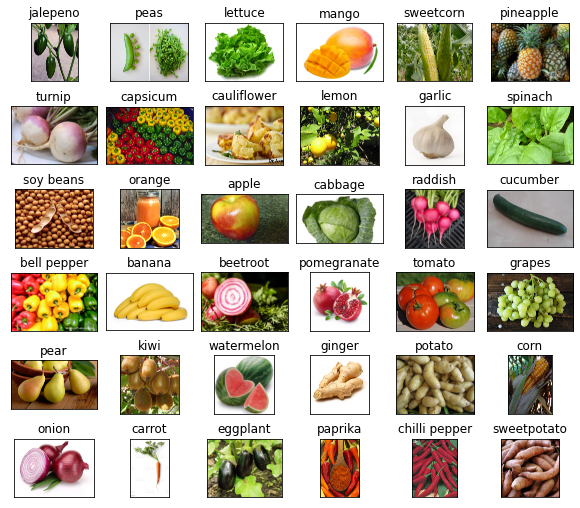

In [12]:
#Create a DataFrame with one Label of each category
df_unique = train_df.copy().drop_duplicates(subset=['Label']).reset_index()

#Display some pictures of the dataset
fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(8,7),
                        subplot_kw={'xticks':[],'yticks':[]})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.Filepath[i]))
    ax.set_title(df_unique.Label[i], fontsize=12)
    
plt.tight_layout(pad=0.5)
plt.show()

## 2.Load the Images with a generator and Data Augmentation

In [13]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input) #transfer learning

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224,224),
    color_model='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_imags = train_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224,224),
    color_made='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224,224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 2780 validated image filenames belonging to 36 classes.
Found 334 validated image filenames belonging to 36 classes.
Found 334 validated image filenames belonging to 36 classes.


In [14]:
#Load the pretrained model
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224,224,3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

2023-01-03 12:04:37.651946: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


9420800/9406464 [==============================] - 0s 0us/step


## **3.Train the model**

In [15]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(36, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss = 'categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_imags,
    batch_size=32,
    epochs=5,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)

2023-01-03 12:04:47.755206: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5
87/87 [==============================] - 222s 3s/step - loss: 1.7254 - accuracy: 0.5403 - val_loss: 0.5267 - val_accuracy: 0.8383
Epoch 2/5
87/87 [==============================] - 179s 2s/step - loss: 0.5734 - accuracy: 0.8162 - val_loss: 0.3104 - val_accuracy: 0.9132
Epoch 3/5
87/87 [==============================] - 176s 2s/step - loss: 0.3389 - accuracy: 0.8921 - val_loss: 0.2276 - val_accuracy: 0.9371
Epoch 4/5
87/87 [==============================] - 175s 2s/step - loss: 0.2102 - accuracy: 0.9317 - val_loss: 0.2054 - val_accuracy: 0.9431
Epoch 5/5
87/87 [==============================] - 174s 2s/step - loss: 0.1515 - accuracy: 0.9550 - val_loss: 0.1570 - val_accuracy: 0.9581


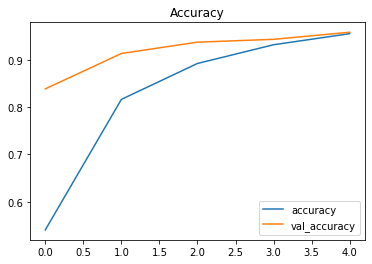

In [16]:
pd.DataFrame(history.history)[['accuracy','val_accuracy',]].plot()
plt.title('Accuracy')
plt.show()

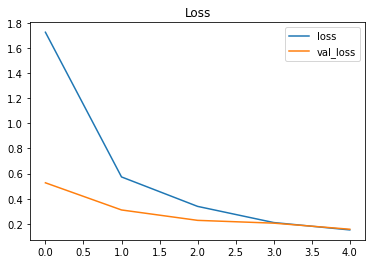

In [17]:
pd.DataFrame(history.history)[['loss','val_loss',]].plot()
plt.title('Loss')
plt.show()

## 4. **Visualize the Result**

In [18]:
#Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

#Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

y_test = [labels[k] for k in test_images.classes]

In [19]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test,pred)
print(f'Accuracy on the test set: {100*acc:.2f}%')

Accuracy on the test set: 95.81%


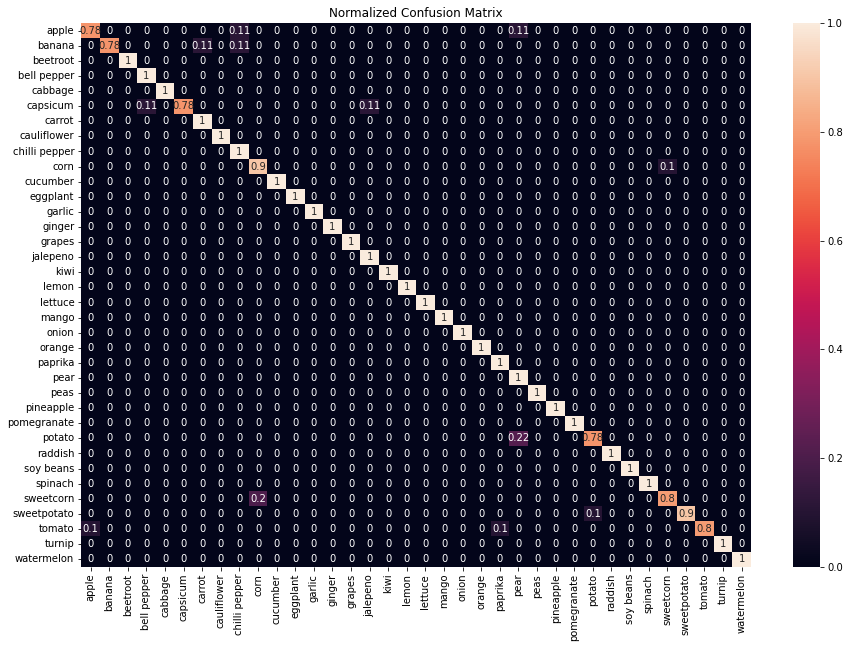

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix  =confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize=(15,10))
sns.heatmap(cf_matrix,
           annot=True,
           xticklabels = sorted(set(y_test)),
           yticklabels = sorted(set(y_test)),
           )
plt.title('Normalized Confusion Matrix')
plt.show()

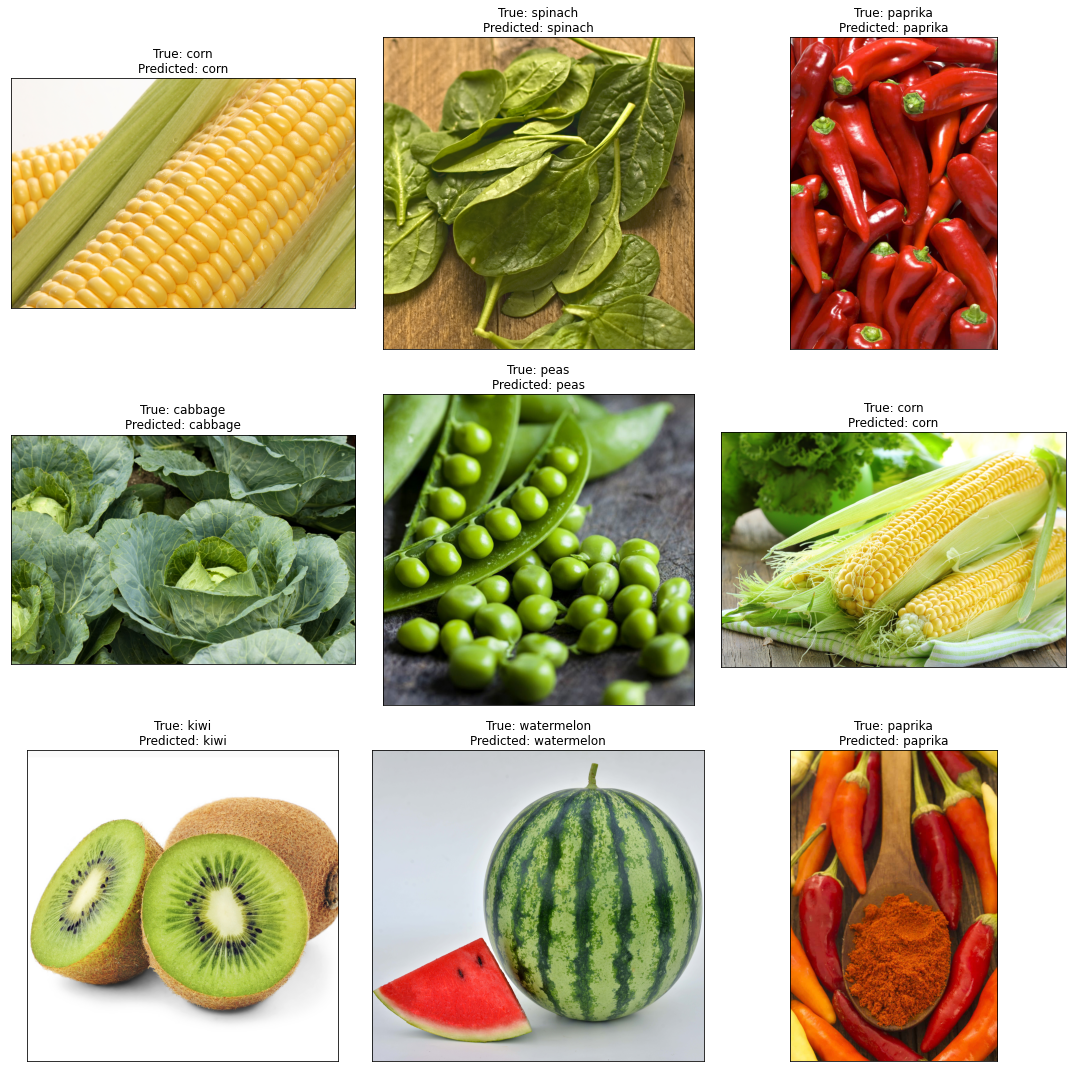

In [21]:
#Display some pictures of the dataset with their labels and the predictions
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15,15),
                        subplot_kw={'xticks':[],'yticks':[]})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f'True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}')
plt.tight_layout()
plt.show()

## **5. Class activation heatmap for image classfication**

Code adapted from keras.io

## **Grad-CAM algorithm**

In [26]:
import matplotlib.cm as cm
import tensorflow as tf

def get_img_array(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a 'batch'
    # of size 'size'
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    
    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
        
    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)
    
    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # We multiply each channel in the feature map array
    # by 'how important this channel is' with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = tf.tensordot(last_conv_layer_output, pooled_grads[..., tf.newaxis], axes=1)
    heatmap = tf.squeeze(heatmap)
    
    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradient(img_path, heatmap, cam_path='cam.jpg', alpha=0.4):
    # Load the original image
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)
    
    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255*heatmap)
    
    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap('jet')

    # Use RGB values of colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    # display(Image(cam_path))

    return cam_path

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

last_conv_layer_name = 'Conv_1'
img_size = (224,224)

#Remove the last layer's softmax
model.layers[-1].activation = None



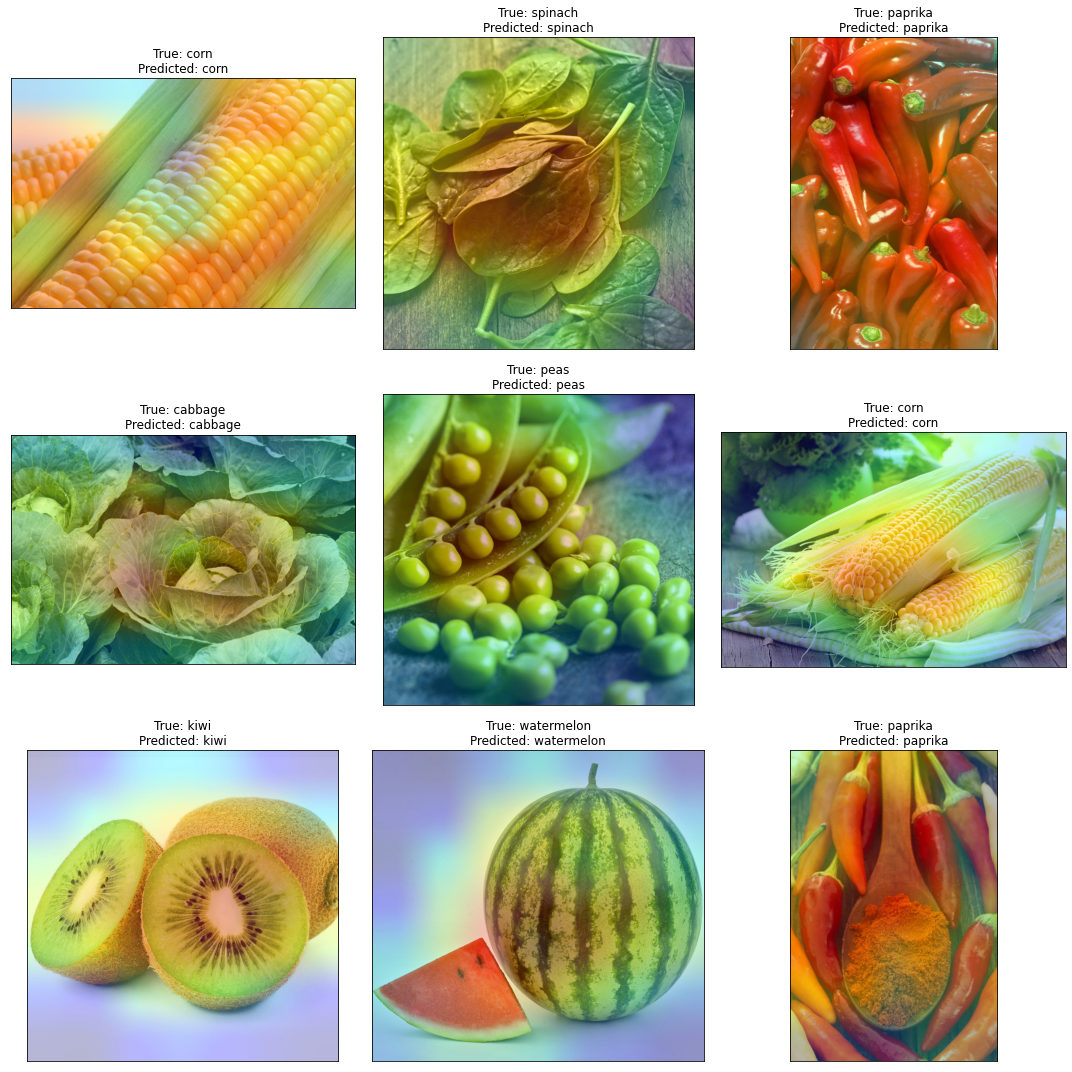

In [28]:
#Display the part of the pictures used by neural network to classify the pictures
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15,15),
                        subplot_kw={"xticks":[],"yticks":[]})

for i, ax in enumerate(axes.flat):
    img_path = test_df.Filepath.iloc[i]
    img_array = preprocess_input(get_img_array(img_path, size=img_size))
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    cam_path = save_and_display_gradient(img_path, heatmap)
    ax.imshow(plt.imread(cam_path))
    ax.set_title(f'True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}')
plt.tight_layout()
plt.show()

In [29]:
def output(location):
    from tensorflow.keras.preprocessing.image import load_img,img_to_array
    img = load_img(location,target_size=(224,224,3))
    img = img_to_array(img)
    img = img/255
    img = np.expand_dims(img,[0])
    answer = model.predict(img)
    y_class = answer.argmax(axis=-1)
    y = " ".join(str(x) for x in y_class)
    y = int(y)
    res = labels[y]
    return res

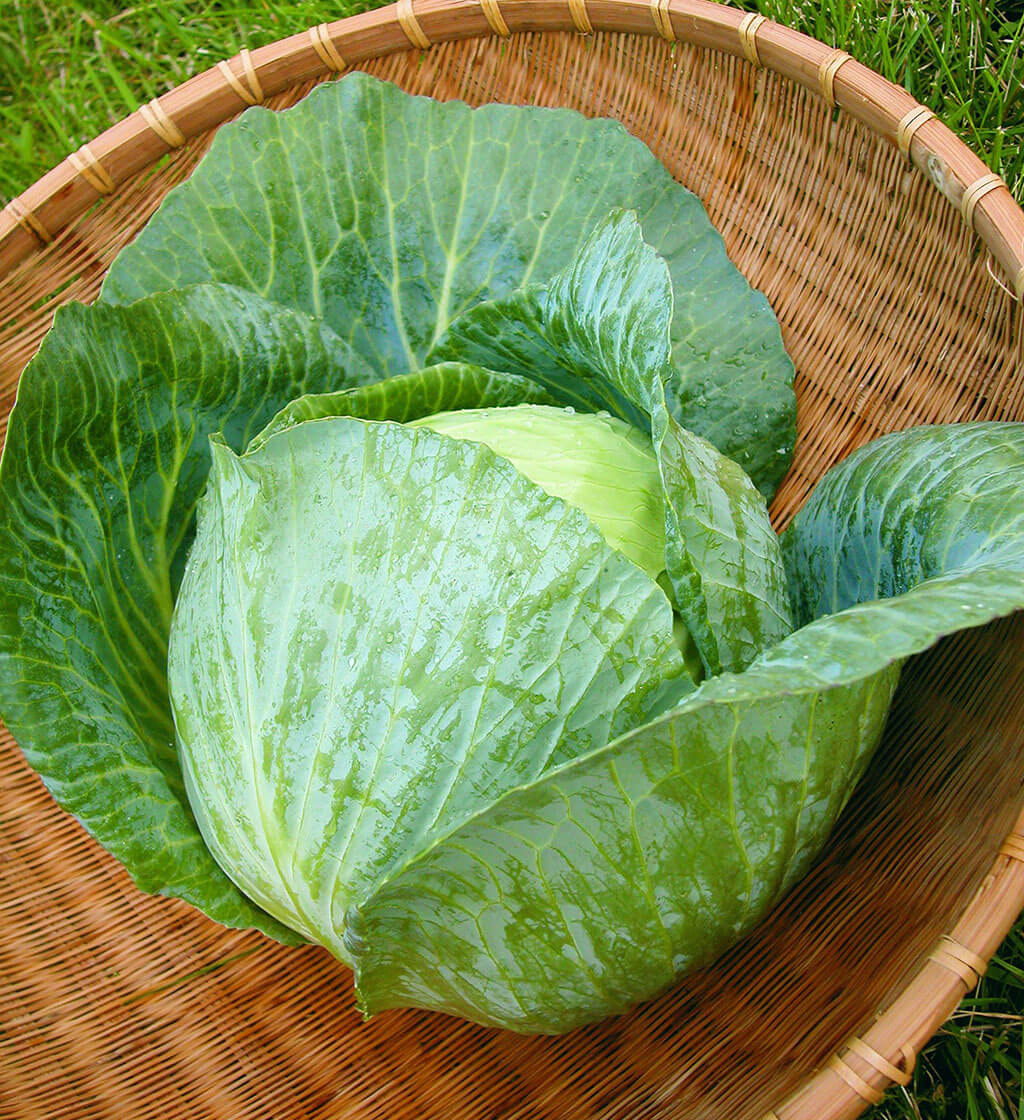

In [30]:
from IPython.display import display
from PIL import Image

location = '/kaggle/input/fruit-and-vegetable-image-recognition/validation/cabbage/Image_1.jpg'
display(Image.open(location))

In [31]:
img = output(location)
img

'cabbage'

In [32]:
model.save('FruitModel.h5')

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
